In [1]:
import warnings
warnings.filterwarnings("ignore")

import requests
import numpy as np
import pandas as pd
import geopandas as gpd # GeoPandas library for spatial analytics
from shapely.geometry import shape
from shapely.geometry import shape

from datetime import datetime, timedelta

In [2]:
df_film= pd.read_csv(r'../data/Film_Permits.csv')

In [6]:
df_film['ParkingHeld'][1]

'COVERT ST between WYCKOFF AVENUE and IRVING AVENUE,  IRVING AVE between ELDERT ST and COVERT ST'

<AxesSubplot:>

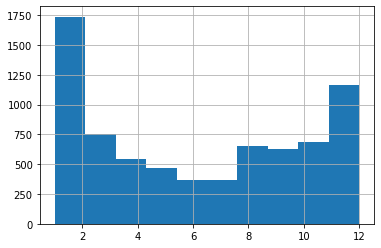

In [28]:
pd.to_datetime(df_film['StartDateTime']).dt.month.hist()

In [7]:
df_film['OFT_Text'] = df_film['ParkingHeld'].str.split(',')
df_film['OFT_Text'] 

0       [SUTTON STREET between NORMAN AVENUE and NASSA...
1       [COVERT ST between WYCKOFF AVENUE and IRVING A...
2       [WHITE STREET between SEIGEL STREET and MOORE ...
3       [BARCLAY STREET between BROADWAY and CHURCH ST...
4       [WEST   13 STREET between 10 AVENUE and WASHIN...
                              ...                        
7362    [WEBSTER AVENUE between EAST  235 STREET and E...
7363    [PROVOST STREET between PAIDGE AVENUE and HURO...
7364    [EAST   11 STREET between 3 AVENUE and 4 AVENU...
7365    [HICKS STREET between HUNTINGTON STREET and WE...
7366    [PEARL STREET between PECK SLIP and BEEKMAN ST...
Name: OFT_Text, Length: 7367, dtype: object

In [30]:
import pickle

In [31]:
# create the cache-like database to store the query.

data = {}
oft_lookup = {}
def getOFT(url):
    data = oft_lookup.get(url)
    if url not in oft_lookup:
        r = requests.get(url)
        data = r.json()
        oft_lookup[url] = data 
    return data    


In [32]:
segidlookup=[]

def getGeom(row):
    boro = row['Borough']
    #print(boro)
    segids = []
    for oft in row['OFT_Text']:
        oft_1 = oft.strip()
        try:
            on_street = oft_1.split('between')[0]
            from_street, to_street  = oft_1.split('between')[1].split('and')

            #print(on_street, from_street, to_street)

            url = f'https://www.locationservice.nyc/locationserviceapi//api/Block?OnStreet={on_street}&CrossStreetOne={from_street}&CrossStreetTwo={to_street}&Borough={boro}&BlockType=ExtendedStretch&ExtendedStretchType=Blockface&'
            data = getOFT(url)
            #print(data)
            if 'BlockFaceList' in data:
                for i in data['BlockFaceList']:
                    if 'SegmentID' in i:
                        segids.append(i['SegmentID'])
                        segidlookup.append({
                            'EventID': row['EventID'],
                            'SegmentID': i['SegmentID']
                        })
        except:
            #print(oft_1)
            continue
                    
    return segids
      

df_film['segids'] = df_film.apply(getGeom, axis = 1)

In [33]:
df_film.head()

,EventID,EventType,StartDateTime,EndDateTime,EnteredOn,EventAgency,ParkingHeld,Borough,CommunityBoard(s),PolicePrecinct(s),Category,SubCategoryName,Country,ZipCode(s),OFT_Text,segids
0,628327,Shooting Permit,03/08/2022 07:00:00 AM,03/08/2022 07:00:00 PM,02/28/2022 11:13:50 AM,"Mayor's Office of Film, Theatre & Broadcasting",SUTTON STREET between NORMAN AVENUE and NASSAU...,Brooklyn,1,94,Television,Pilot,United States of America,11222,[SUTTON STREET between NORMAN AVENUE and NASSA...,[0065898]
1,629351,Shooting Permit,03/08/2022 07:00:00 AM,03/08/2022 10:00:00 PM,03/03/2022 02:51:17 PM,"Mayor's Office of Film, Theatre & Broadcasting",COVERT ST between WYCKOFF AVENUE and IRVING AV...,Queens,5,104,Television,Episodic series,United States of America,"11237, 11385",[COVERT ST between WYCKOFF AVENUE and IRVING A...,[0048509]
2,629319,Shooting Permit,03/08/2022 07:00:00 AM,03/08/2022 09:00:00 PM,03/03/2022 01:49:15 PM,"Mayor's Office of Film, Theatre & Broadcasting",WHITE STREET between SEIGEL STREET and MOORE S...,Brooklyn,1,90,Television,Cable-episodic,United States of America,11206,[WHITE STREET between SEIGEL STREET and MOORE ...,"[0044431, 0044457, 0044453, 0110472]"
3,629309,Shooting Permit,03/08/2022 07:00:00 AM,03/08/2022 08:00:00 PM,03/03/2022 01:30:28 PM,"Mayor's Office of Film, Theatre & Broadcasting",BARCLAY STREET between BROADWAY and CHURCH STR...,Manhattan,1,1,Television,Episodic series,United States of America,"10007, 10013, 10282",[BARCLAY STREET between BROADWAY and CHURCH ST...,"[0023363, 0023369, 0023397, 0023400, 0293659, ..."
4,629504,Shooting Permit,03/08/2022 04:00:00 PM,03/09/2022 06:00:00 AM,03/04/2022 08:44:43 AM,"Mayor's Office of Film, Theatre & Broadcasting",WEST 13 STREET between 10 AVENUE and WASHING...,Manhattan,2,6,Film,Feature,United States of America,10014,[WEST 13 STREET between 10 AVENUE and WASHIN...,"[0236862, 0236863, 0143228, 0032026]"


In [34]:
df_segidlookup = pd.DataFrame(segidlookup)
df_segidlookup

,EventID,SegmentID
0,628327,0065898
1,629351,0048509
2,629319,0044431
3,629319,0044457
4,629319,0044453
...,...,...
37026,623949,0105864
37027,623949,0023296
37028,623949,0023304
37029,623949,0023303


In [35]:
df_film_seg = df_film.merge(df_segidlookup,how='left',on='EventID')

In [36]:
df_film_seg.to_csv('../output/film permit_city_seg.csv')  

In [37]:
lion = gpd.read_file("../vector/lion_line" )

In [38]:
lion_sel = lion[['OBJECTID','SegmentID','Join_ID','geometry']]
lion_sel.head()

,OBJECTID,SegmentID,Join_ID,geometry
0,1.0,0078126,2251001000000,"LINESTRING (1010964.447 241812.261, 1011265.49..."
1,2.0,0079796,2798401000000,"LINESTRING (1011576.687 255023.583, 1011335.15..."
2,3.0,0077356,2728001000000,"LINESTRING (1011600.676 239639.743, 1011785.79..."
3,4.0,0077356,21279502000000X,"LINESTRING (1011600.676 239639.743, 1011785.79..."
4,5.0,0077356,21279503000000X,"LINESTRING (1011600.676 239639.743, 1011785.79..."


In [39]:
df_film_lion = df_film_seg.merge(lion_sel,how='left',on='SegmentID')
df_film_lion.head(2)

,EventID,EventType,StartDateTime,EndDateTime,EnteredOn,EventAgency,ParkingHeld,Borough,CommunityBoard(s),PolicePrecinct(s),Category,SubCategoryName,Country,ZipCode(s),OFT_Text,segids,SegmentID,OBJECTID,Join_ID,geometry
0,628327,Shooting Permit,03/08/2022 07:00:00 AM,03/08/2022 07:00:00 PM,02/28/2022 11:13:50 AM,"Mayor's Office of Film, Theatre & Broadcasting",SUTTON STREET between NORMAN AVENUE and NASSAU...,Brooklyn,1,94,Television,Pilot,United States of America,11222,[SUTTON STREET between NORMAN AVENUE and NASSA...,[0065898],0065898,39195.0,3762801000000,"LINESTRING (1000675.780 203773.602, 1000590.62..."
1,628327,Shooting Permit,03/08/2022 07:00:00 AM,03/08/2022 07:00:00 PM,02/28/2022 11:13:50 AM,"Mayor's Office of Film, Theatre & Broadcasting",SUTTON STREET between NORMAN AVENUE and NASSAU...,Brooklyn,1,94,Television,Pilot,United States of America,11222,[SUTTON STREET between NORMAN AVENUE and NASSA...,[0065898],0065898,39196.0,36363001000000V,"LINESTRING (1000675.780 203773.602, 1000590.62..."


In [40]:
df_film_lion['geometry'].isnull().sum(axis = 0)

1578

In [41]:
df_film_lion[df_film_lion['geometry'].isnull()==True].head(2)

,EventID,EventType,StartDateTime,EndDateTime,EnteredOn,EventAgency,ParkingHeld,Borough,CommunityBoard(s),PolicePrecinct(s),Category,SubCategoryName,Country,ZipCode(s),OFT_Text,segids,SegmentID,OBJECTID,Join_ID,geometry
19,629309,Shooting Permit,03/08/2022 07:00:00 AM,03/08/2022 08:00:00 PM,03/03/2022 01:30:28 PM,"Mayor's Office of Film, Theatre & Broadcasting",BARCLAY STREET between BROADWAY and CHURCH STR...,Manhattan,1,1,Television,Episodic series,United States of America,"10007, 10013, 10282",[BARCLAY STREET between BROADWAY and CHURCH ST...,"[0023363, 0023369, 0023397, 0023400, 0293659, ...",0031489,NaN,NaN,None
26,629546,Shooting Permit,03/08/2022 06:00:00 AM,03/08/2022 10:00:00 PM,03/04/2022 10:24:22 AM,"Mayor's Office of Film, Theatre & Broadcasting",20 AVENUE between SHORE BOULEVARD and 21 STREET,Queens,1,114,Television,Episodic series,United States of America,11105,[20 AVENUE between SHORE BOULEVARD and 21 STREET],[],NaN,NaN,NaN,None


In [42]:
gdf_film_lion = gpd.GeoDataFrame(df_film_lion, crs="EPSG:4326").set_geometry('geometry')
gdf_film_lion_output = gdf_film_lion.drop(columns=['OFT_Text','segids'])
gdf_film_lion_output.to_file('../output/film permit_city.shp')  

# Segment Count

In [74]:
df_seg_count = df_film_seg[['EventID','SegmentID']].groupby('SegmentID').count()
df_seg_count = df_seg_count.rename(columns={'EventID':'counts'}).reset_index()
df_seg_count.sort_values(by='counts', ascending=False)

,SegmentID,counts
3016,0035681,349
2951,0035515,229
2955,0035520,220
2947,0035511,208
2945,0035507,173
...,...,...
5435,0075582,1
2339,0033278,1
5437,0075592,1
5438,0075616,1


In [75]:
df_film_lion_count = df_seg_count.merge(lion_sel,how='left',on='SegmentID')
df_film_lion_count = gpd.GeoDataFrame(df_film_lion_count, crs="EPSG:4326").set_geometry('geometry')
df_film_lion_count.to_file('../output/permit_city_segment_count.shp')  

In [4]:
df_film_lion_count = gpd.read_file('../output/permit_city_segment_count.shp')  

In [35]:
df_film_lion_count = df_film_lion_count.sort_values('Counts',ascending=False)
df_film_lion_count.head(20)

,SegmentID,Counts,CD,CB,Street,geometry
6359,0035681,349,33,301,MONITOR STREET,"LINESTRING (999919.040 205536.203, 999847.829 ..."
6226,0035515,229,33,301,CALYER STREET,"LINESTRING (998361.937 205063.691, 998591.352 ..."
6233,0035520,220,33,301,CALYER STREET,"LINESTRING (998591.352 205163.176, 998820.922 ..."
6222,0035511,208,33,301,JEWEL STREET,"LINESTRING (998755.108 204787.219, 998591.352 ..."
6220,0035507,173,33,301,DIAMOND STREET,"LINESTRING (998525.443 204687.439, 998361.937 ..."
6358,0035676,170,33,301,NORTH HENRY STREET,"LINESTRING (999661.937 205507.703, 999600.658 ..."
10630,0048509,150,37,304,COVERT STREET,"LINESTRING (1010582.250 192025.794, 1010582.25..."
10628,0048509,150,34,304,COVERT STREET,"LINESTRING (1010582.250 192025.795, 1010582.25..."
10629,0048509,150,34,405,COVERT STREET,"LINESTRING (1010582.250 192025.795, 1010809.74..."
6047,0035023,149,33,301,EAGLE STREET,"LINESTRING (995324.180 206940.246, 995776.604 ..."


In [27]:
df_seg_count = df_film_lion_count[['SegmentID','Counts','Street']]
df_seg_count =df_seg_count.reset_index(drop=True)
df_seg_count.to_csv('../data/segment counts.csv')

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

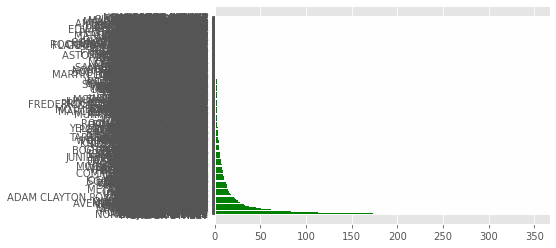

In [33]:
plt.barh(df_film_lion_count['Street'],df_film_lion_count['Counts'], color='green')
# plt.ylabel("Energy Source")
# plt.xlabel("Energy Output (GJ)")
# plt.title("Energy output from various fuel sources")

# plt.yticks(x_pos, x)

plt.show()